# Financial Market Analysis using Recurrent Neural Network

## What this notebook is about 

1. We present a stock market modeling and prediction using RNNs. 
2. We begin with the simplest case of one stock (e.g., MSFT) and one feature (e.g., daily open price), and use a rolling time window of n days to forecast the price on day n+1. We train three kinds of LSTM RNNs:

    2.1 A regressor with mean square error loss. This serves as a baseline model. 

    2.2 A regressor with pinball loss for quantile regression, which outputs the confidence intervals. 

    2.3 A classifier with binary crossentropy loss for predicting loss or gain on day n+1 compared to day n. 

3. To find common features of market movement, we proceed to combine various stocks data to avoid NN model to specialize onto a specific stock. This is achieved by stacking various stocks along the sample axis. We shall run the same analysis to (2).

4. We proceed to do multiday forecasting, using pinball loss for quantile regression.

5. Finally we conduct an analysis of multiple features. One example is instead of stacking different stocks along the sample axis, we stack them along the feature axis. 

    5.1 This should also help with extracting commonalities of various stocks, and therefore a general model. 

# 1. Data preparation, EDA, and preprocessing
## 1.1 EDA

In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

plt.style.use('fivethirtyeight')

import yfinance as yahooFinance # Yahoo Finance has a nice API
tickers = ['^IXIC','MSFT','AAPL','NVDA','GOOGL',
           'AMZN','META','TSM','TSLA','JPM',
           'ASML','AMD','BABA','CSCO','PFE']
dfs = {ticker:yahooFinance.Ticker(ticker).history(period='max') for ticker in tickers}

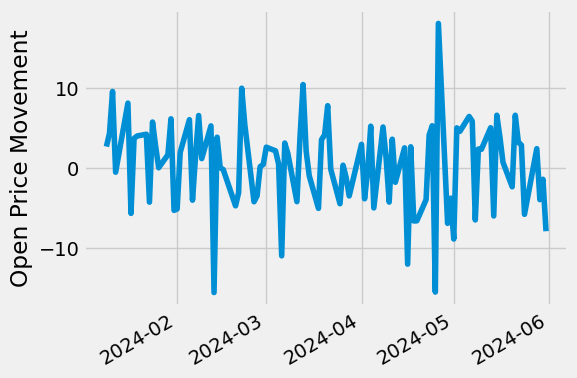

In [327]:
# with plt.style.context('fivethirtyeight'):
dfs['MSFT']['Open'].diff()[-100:].plot(figsize=(6,4))
# plt.legend([],[])
plt.xlabel('')
plt.ylabel("Open Price Movement")
plt.tight_layout()
plt.savefig("abc.png",dpi=600)
plt.show()

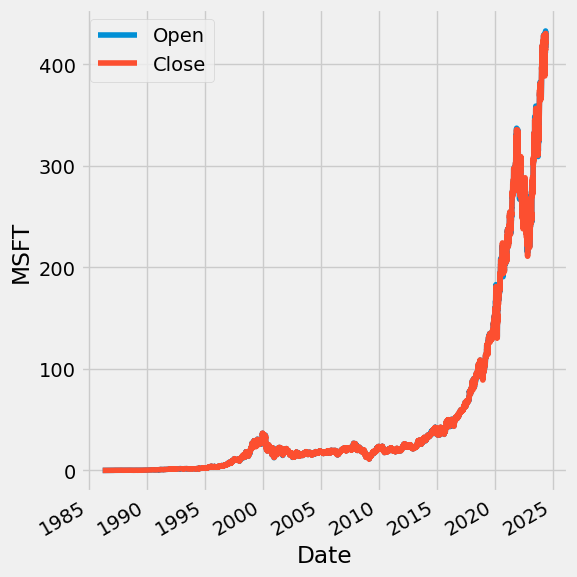

In [277]:
dfs['MSFT'][['Open','Close']].plot(figsize=(6,6))
plt.ylabel("MSFT")
plt.tight_layout()
plt.savefig("abc.png",dpi=600)
plt.show()

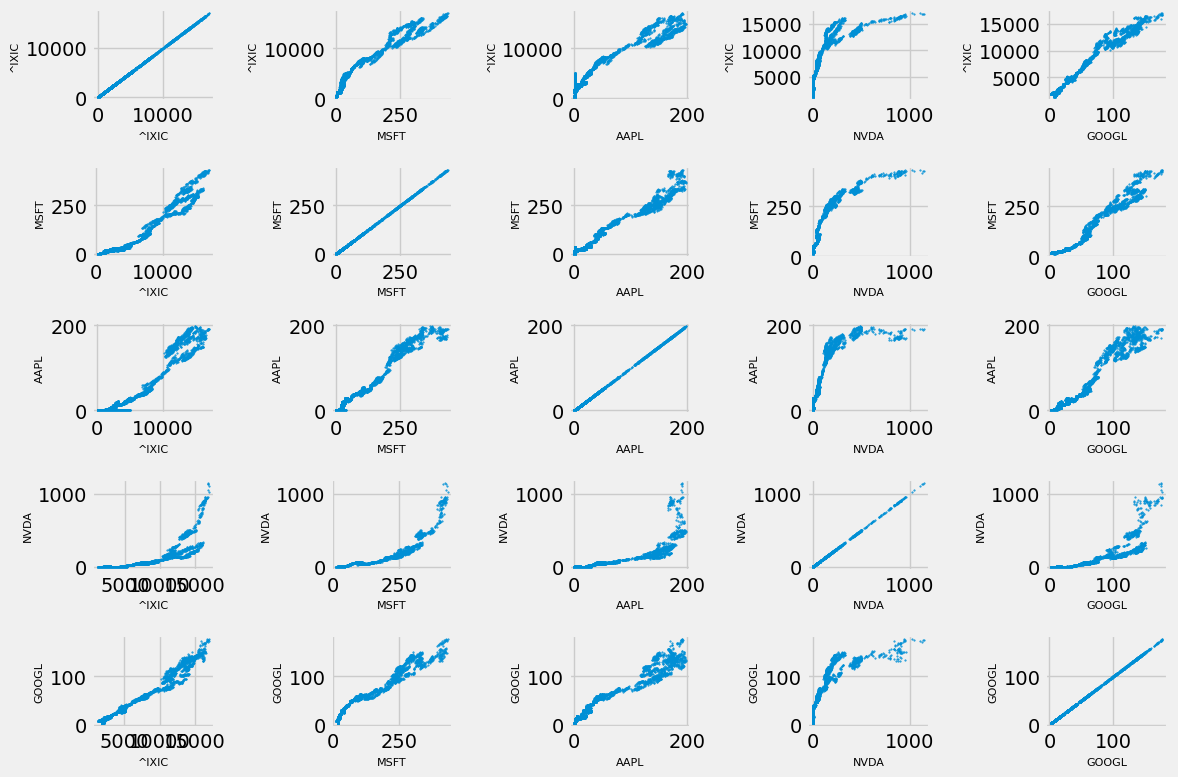

In [279]:
df_collage = pd.DataFrame({tag:dfs[tag]['Open'] for tag in tickers})
tot = 5
fig, ax = plt.subplots(tot,tot,figsize=(12,8))
for i in range(5):
    for j in range(5):
        ax[i,j].plot(df_collage[tickers[j]],df_collage[tickers[i]],'.',ms=1,markeredgecolor=None)
        ax[i,j].set_xlabel(tickers[j],fontsize=8)
        ax[i,j].set_ylabel(tickers[i],fontsize=8)
plt.tight_layout()
plt.show()

## 1.2 Rolling time window

For any given stock, we create rolling time windows of size n_window, and multiday forecasting n_forecast. The data is then transformed into (batch,sequence_length,features). MinMaxScaling is done (necessary for good predictions! see later)

In [349]:
def create_time_windows(df, n_window = 20, n_forecast = 1, _scale = True, _overlapping = True ): 
    '''
        This creates a rolling time window (X,y) from the Pandas DataFrame df, 
        and store it in a numpy array of size (nsamples, n_window/n_forecast, nfeatures)
        n_features referr to open/close/volume etc, while also going through a min-max scaler
    '''
    X, y, scaler = [], [], []
    if _overlapping: # this creates overlapping time windows 
        for i in range(n_window,len(df)-n_forecast):
            tmp = df.iloc[(i-n_window):(i+n_forecast)].to_numpy()
            if _scale:
                sc = MinMaxScaler(feature_range=(0,1))
                tmp = sc.fit_transform(tmp)
                scaler.append(sc)
            X.append(tmp[:n_window,...])
            y.append(tmp[n_window:,...])
    else: # this creates non-overlapping time windows; dramatically reduces the number of samples
        for i in range(len(df)): 
            if (i+1) * (n_window+n_forecast) <= len(df):
                tmp = df.iloc[(i * (n_window+n_forecast)):((i+1)*(n_window+n_forecast))].to_numpy()
                if _scale: 
                    tmp = sc.fit_transform(tmp)
                    scaler.append(sc)
                X.append(tmp[:n_window,...])
                y.append(tmp[n_window:,...])
        
    return {'X':np.array(X), 'y':np.array(y), 'scaler':scaler}

def plot_rolling_time_window(X, y, model = 0, mode = 'test' ):
    ''' 
        This function plots the data in the 9 rolling time windows 
        if model is provided, also plot the prediced values 
    '''
    fig, ax = plt.subplots(3,3,figsize=(8,6),sharex=True,sharey=True)
    for r in range(3):
        for c in range(3):
            idx = np.random.randint(X.shape[0])
            ax[r,c].plot(range(X.shape[1]),X[idx,:,0],"-",label='train')
            ax[r,c].plot(range(X.shape[1],X.shape[1]+y.shape[1]),y[idx,:,0],"-^",label='actual',ms=5)
            if model != 0:
                val = model(X[idx:(idx+1),...])
                ax[r,c].plot(range(X.shape[1],X.shape[1]+y.shape[1]),val[0],"-x",label='pred.',ms=5)
            if r == 0 and c ==0:
                ax[r,c].legend(fontsize=12)
    fig.suptitle(mode)
    plt.tight_layout()
    plt.savefig('abc.png',dpi=600)
    plt.show()
    plt.close()

def plot_train_val_history_regressor(history):
    fig = plt.figure(figsize=(5,4))
    plt.plot(history.history['loss'],'b-',label='loss')
    plt.plot(history.history['val_loss'],'r-',label='val loss')
    plt.ylim([0,1.5*max(history.history['loss'])])
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.legend()
    plt.savefig('abc.png',dpi=600)
    plt.show()
    plt.close(fig)


def plot_1dayforecast(metadata, begin_index=0, models = {}):
    _scaled = len(metadata['scaler']) != 0
    yactual = metadata['y'].copy().reshape(-1,1,1)
    if _scaled:
        for i in range(yactual.shape[0]):
            yactual[i,:,:] = metadata['scaler'][i].inverse_transform(yactual[i,:,:])

    fig,ax = plt.subplots(figsize=(10,5))

    for label, model in models.items():
        ypred = model(metadata['X']).numpy().reshape(-1,1,1)
        if _scaled: 
            for i in range(ypred.shape[0]):
                ypred[i,:,:] = metadata['scaler'][i].inverse_transform(ypred[i,:,:])
        ax.plot(ypred[begin_index:,0,0],"-",label=label,alpha=0.8)
    
    # ax.plot(yactual[(begin_index-1):-1,0,0],"-",label='1 day lag',alpha=0.8)
    ax.plot(yactual[begin_index:,0,0],"k-",label='actual')
    
    ax.legend()
    plt.tight_layout()
    plt.savefig("abc.png",dpi=500)
    plt.show()
    plt.close(fig)


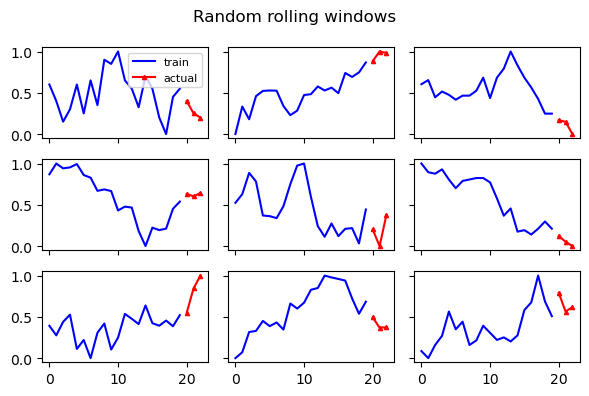

In [134]:
metadata = create_time_windows(pd.DataFrame({'Open':dfs['MSFT']['Open']}), n_window = 20, n_forecast = 3)
plot_rolling_time_window(metadata['X'],metadata['y'],mode='Random rolling windows')

# 2 Neural network modeling
## 2.1 Train test val split 

In [350]:
def train_val_test_split(metadata, test_ratio = 0.2, val_ratio = 0.2):
    '''
        train validation test split
        metadata = {'X':np.array,'y':np.array,'scaler':np.array}
    '''
    N = len(metadata['y'])
    Ntest = int( N * test_ratio )
    Nval = int( (N-Ntest) * val_ratio )
    Ntrain = N - Ntest - Nval 

    if len(metadata['scaler']) != 0:
        train = {'X':metadata['X'][:Ntrain,...],
                'y':metadata['y'][:Ntrain,...],
                'scaler':metadata['scaler'][:Ntrain]}
        
        val = {'X':metadata['X'][Ntrain:(Ntrain+Nval),...],
            'y':metadata['y'][Ntrain:(Ntrain+Nval),...],
            'scaler':metadata['scaler'][Ntrain:(Ntrain+Nval)]}
        
        test = {'X':metadata['X'][(Ntrain+Nval):,...],
                'y':metadata['y'][(Ntrain+Nval):,...],
                'scaler':metadata['scaler'][(Ntrain+Nval):]}
    else:
        train = {'X':metadata['X'][:Ntrain,...],
                'y':metadata['y'][:Ntrain,...],
                'scaler':[]}
        
        val = {'X':metadata['X'][Ntrain:(Ntrain+Nval),...],
            'y':metadata['y'][Ntrain:(Ntrain+Nval),...],
            'scaler':[]}
        
        test = {'X':metadata['X'][(Ntrain+Nval):,...],
                'y':metadata['y'][(Ntrain+Nval):,...],
                'scaler':[]}
        
    return train, val, test 

## 2.1 Task 1

Scalar time series with only one feature. Train a regressor with mean square error loss to use n days of data to forecast opening price on day n+1

In [351]:
n_window, n_forecast, feature, ticker = 40, 1, 'Open', 'MSFT'
metadata = create_time_windows(pd.DataFrame({ticker:dfs[ticker][feature]}), n_window = n_window, n_forecast = n_forecast)
train, val, test = train_val_test_split(metadata)

lstm_regressor_mse = keras.Sequential([keras.Input(shape=(None,1)),
                          keras.layers.LSTM(32,return_sequences=True),
                          keras.layers.Dropout(0.2),
                          keras.layers.LSTM(32,return_sequences=False),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(1)])

lstm_regressor_mse.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='mse')
history = lstm_regressor_mse.fit(train['X'],train['y'], batch_size= 32, verbose = 0,
                     epochs = 100,validation_data=(val['X'],val['y']))

In [379]:
model = lstm_regressor_mse
units = 32
W = model.layers[2].get_weights()[0]
U = model.layers[2].get_weights()[1]
b = model.layers[2].get_weights()[2]

W_i = W[:, :units]
W_f = W[:, units: units * 2]
W_c = W[:, units * 2: units * 3]
W_o = W[:, units * 3:]

U_i = U[:, :units]
U_f = U[:, units: units * 2]
U_c = U[:, units * 2: units * 3]
U_o = U[:, units * 3:]

b_i = b[:units]
b_f = b[units: units * 2]
b_c = b[units * 2: units * 3]
b_o = b[units * 3:]

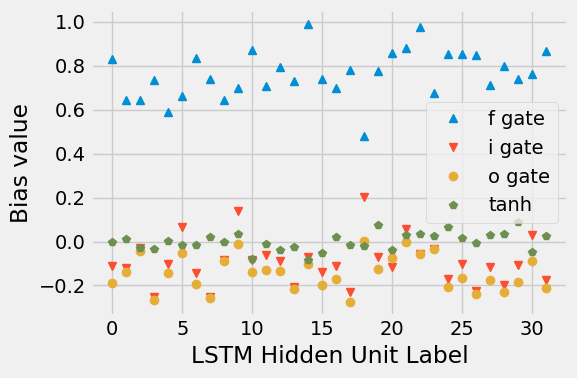

In [393]:
# this shows the "forget" gate has a higher bias value than the "input" gate. This indeed make c a "longer"-term memory.
fig = plt.figure(figsize=(6,4))
plt.plot(b_f,'^',label='f gate')
plt.plot(b_i,'v',label='i gate')
plt.plot(b_o,'o',label='o gate')
plt.plot(b_c,'p',label='tanh')
# plt.plot(W_i.flatten(),'o',label='i gate')
# plt.plot(W_f.flatten(),'<',label='f gate')
# plt.title('Layer 2 LSTM bias values for all hidden units', fontsize=15)
plt.legend()
plt.xlabel('LSTM Hidden Unit Label')
plt.ylabel('Bias value')
plt.tight_layout()
plt.savefig('abc.png',dpi=600)
plt.show()

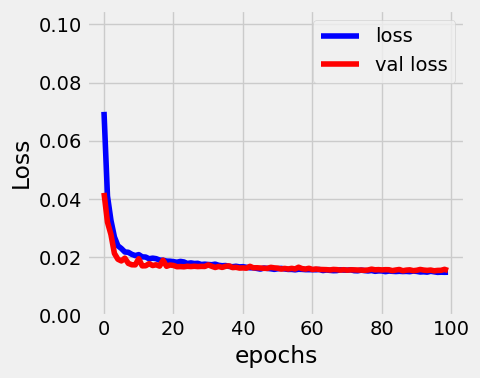

In [352]:
plot_train_val_history_regressor(history)

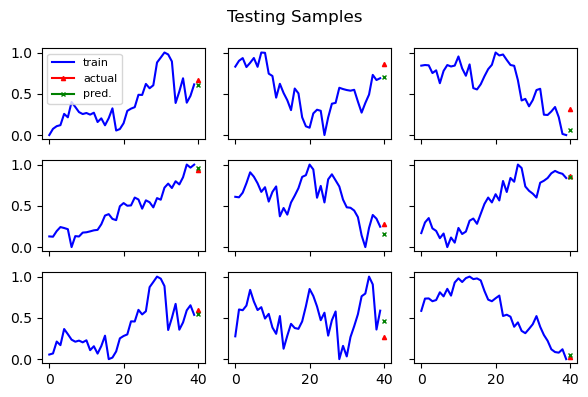

In [123]:
plot_rolling_time_window(test['X'],test['y'],model=lstm_regressor_mse,mode='Testing Samples')

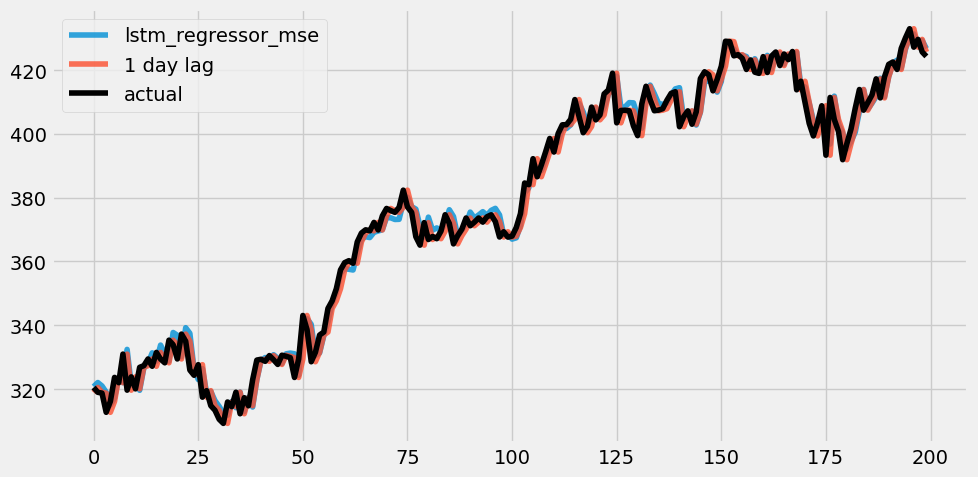

In [303]:
plot_1dayforecast(test,begin_index=-200,models={'lstm_regressor_mse':lstm_regressor_mse})

## 2.2 Task 2

Scalar time series with only one feature. Train a regressor with pinball loss to use n days of data to forecast opening price on day n+1, with a quantile uncertainty 

In [292]:
def quantile_loss(q, y, y_p):
    ''' 
        Quantile loss function; e.g. q = 75% trains a regressor such that there's 75% confidence that y_p is smaller than y 
    '''
    e = y-y_p
    return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e))

n_window, n_forecast, feature, ticker = 40, 1, 'Open', 'MSFT'
metadata = create_time_windows(pd.DataFrame({ticker:dfs[ticker][feature]}), n_window = n_window, n_forecast = n_forecast)
train, val, test = train_val_test_split(metadata)

quantiles = [0.05,0.5,0.95]
quantile_models = []
histories = []

for q in quantiles: 
    print(f"Quantile {q} model training:")
    lstm_regressor_quantile = keras.Sequential([keras.Input(shape=(None,1)),
                            keras.layers.LSTM(32,return_sequences=True),
                            keras.layers.Dropout(0.2),
                            keras.layers.LSTM(32,return_sequences=False),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(1)])
    lstm_regressor_quantile.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=lambda y, yp: quantile_loss(q,y,yp))
    history = lstm_regressor_quantile.fit(train['X'],train['y'], batch_size= 32,
                                     epochs = 50,validation_data=(val['X'],val['y']))
    quantile_models.append(lstm_regressor_quantile)
    histories.append(history)

Quantile 0.05 model training:
Epoch 1/50


192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0256 - val_loss: 0.0217
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0201 - val_loss: 0.0192
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0183 - val_loss: 0.0183
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0174 - val_loss: 0.0174
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0166 - val_loss: 0.0162
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0157 - val_loss: 0.0173
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0157 - val_loss: 0.0163
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0156 - val_loss: 0.0156
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0158 - val_loss: 0.0151
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0148 - val_loss: 0.0152
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0146 - val_loss: 0.0163
Epoch 12/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

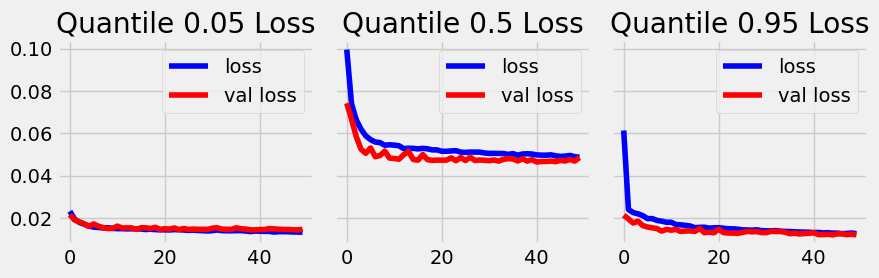

In [293]:
fig, ax = plt.subplots(1,len(histories),figsize=(3*len(histories),3),sharex=True,sharey=True)
for i in range(len(histories)):
    history = histories[i]
    ax[i].plot(history.history['loss'],'b-',label='loss')
    ax[i].plot(history.history['val_loss'],'r-',label='val loss')
    # ax[i].set_ylim([0,1.5*max(history.history['loss'])])
    ax[i].legend()
    ax[i].set_title(f'Quantile {quantiles[i]} Loss')
plt.tight_layout()
plt.show()
plt.close(fig)

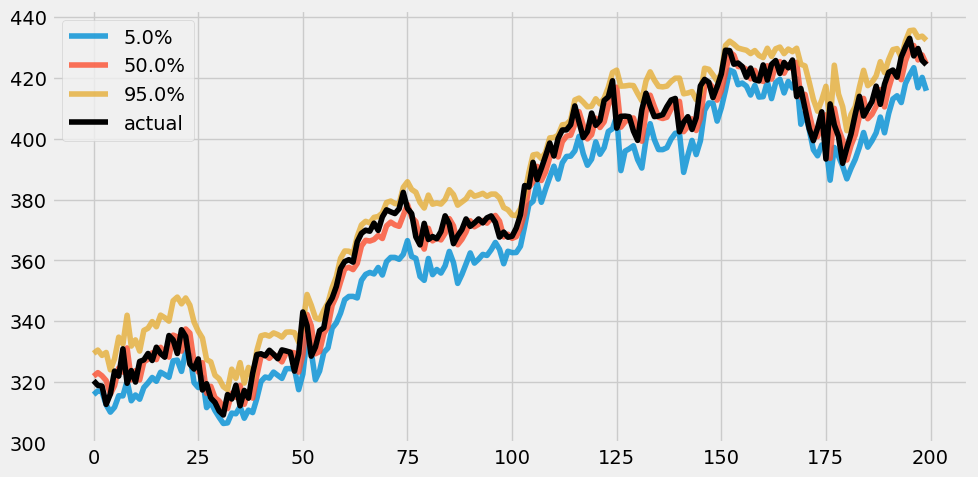

In [294]:
plot_1dayforecast(test,begin_index=-200,models={f'{quantiles[i]*100}%':quantile_models[i] for i in range(len(quantiles))})

# 2.2 Task 3
Scalar time series with only one feature. Train a classifier with binary entropy loss to see if the stock price on day n+1 is higher/lower than on day n 

In [304]:
n_window, n_forecast, feature, ticker = 12, 1, 'Open', 'MSFT'
metadata = create_time_windows(pd.DataFrame({ticker:dfs[ticker][feature]}), n_window = n_window, n_forecast = n_forecast)
train, val, test = train_val_test_split(metadata)
trainy = (np.sign(train['y'] - train['X'][:,-1:,:]) + 1)/2
valy = (np.sign(val['y'] - val['X'][:,-1:,:]) + 1)/2
testy = (np.sign(test['y'] - test['X'][:,-1:,:]) + 1)/2

print(f"Percentage of gains: {trainy.sum()/trainy.shape[0]}" )


Percentage of gains: 0.5142114666233555


In [305]:
lstm_classifier_crossentropy = keras.Sequential([keras.Input(shape=(None,1)),
                          keras.layers.LSTM(20,return_sequences=True),
                          keras.layers.Dropout(0.2),
                          keras.layers.LSTM(20,return_sequences=False),
                          keras.layers.Dense(1,activation='sigmoid')])

lstm_classifier_crossentropy.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),loss='binary_crossentropy',metrics=['accuracy'])
history = lstm_classifier_crossentropy.fit(train['X'],trainy, batch_size= 32,
                     epochs = 100,validation_data=(val['X'],valy))

Epoch 1/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5357 - loss: 0.6882 - val_accuracy: 0.5673 - val_loss: 0.6814
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5770 - loss: 0.6717 - val_accuracy: 0.6101 - val_loss: 0.6550
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5963 - loss: 0.6611 - val_accuracy: 0.6160 - val_loss: 0.6506
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6196 - loss: 0.6502 - val_accuracy: 0.6329 - val_loss: 0.6414
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6430 - loss: 0.6307 - val_accuracy: 0.6491 - val_loss: 0.5947
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6434 - loss: 0.5958 - val_accuracy: 0.6894 - val_loss: 0.5596
Epoch 7/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6878 - loss: 0.5605 - val_accuracy: 0.7271 - val_loss: 0.4973
Epoch 8/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7073 - loss: 0.5231 - val_accu

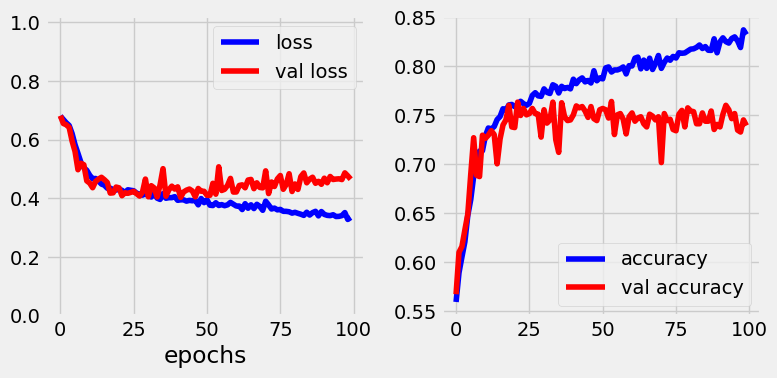

In [309]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(history.history['loss'],'b-',label='loss')
ax[0].plot(history.history['val_loss'],'r-',label='val loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylim([0,1.5*max(history.history['loss'])])
ax[0].legend()
ax[1].plot(history.history['accuracy'],'b-',label='accuracy')
ax[1].plot(history.history['val_accuracy'],'r-',label='val accuracy')
ax[1].legend()
plt.tight_layout()
plt.savefig('abc.png',dpi=600)
plt.show()
plt.close(fig)

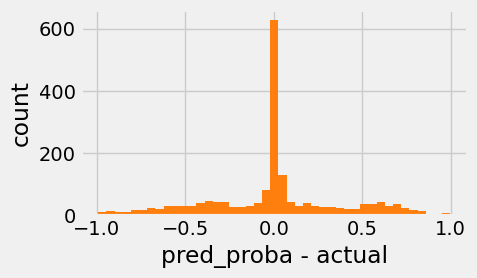

In [330]:
# histogram plot to show the predict market movement (gain/loss) versus actual
ypred = lstm_classifier_crossentropy(test['X']).numpy().flatten()
fig = plt.figure(figsize=(5,3))
plt.hist(ypred-testy.flatten(),bins=43,color='tab:orange')
plt.xlabel('pred_proba - actual')
plt.ylabel('count')
plt.tight_layout()
plt.savefig('abc.png',dpi=600)
plt.show()
plt.close(fig)

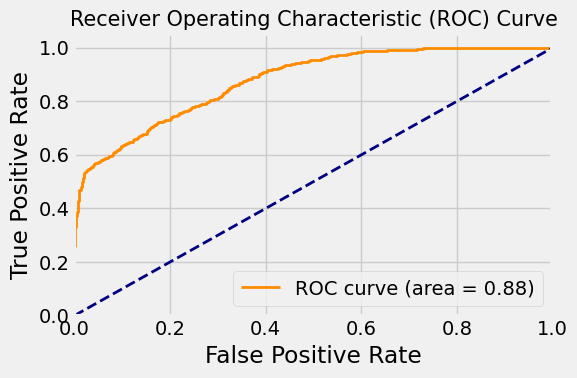

In [331]:
# roc curve 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testy.flatten(), ypred)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
fig = plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve',fontsize=15)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('abc.png',dpi=600)
plt.show()
plt.close(fig)

# 3. Common features among stocks 
Train a generic LSTM that can find common movement features of all stocks 

In [343]:
n_window, n_forecast, feature, _tic = 40, 1, 'Open', ['MSFT','GOOGL','NVDA','META']
ticker = _tic[0]
metadata = create_time_windows(pd.DataFrame({ticker:dfs[ticker][feature]}), n_window = n_window, n_forecast = n_forecast)
train, val, test = train_val_test_split(metadata)
for ticker in _tic[1:]:
    metadata = create_time_windows(pd.DataFrame({ticker:dfs[ticker][feature]}), n_window = n_window, n_forecast = n_forecast)
    a, b, c = train_val_test_split(metadata)
    for key in ['X','y']:
        train[key] = np.concatenate([train[key],a[key]],axis=0)
        val[key] = np.concatenate([val[key],b[key]],axis=0)
        test[key] = np.concatenate([test[key],c[key]],axis=0)
    train['scaler'] = train['scaler'] + a['scaler']
    val['scaler'] = val['scaler'] + b['scaler']
    test['scaler'] = test['scaler'] + c['scaler']

In [344]:
lstm_regressor_mse = keras.Sequential([keras.Input(shape=(None,1)),
                          keras.layers.LSTM(32,return_sequences=True),
                          keras.layers.Dropout(0.2),
                          keras.layers.LSTM(32,return_sequences=False),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(1)])

lstm_regressor_mse.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='mse')
history = lstm_regressor_mse.fit(train['X'],train['y'], batch_size= 32,
                     epochs = 100,validation_data=(val['X'],val['y']))

Epoch 1/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0869 - val_loss: 0.0249
Epoch 2/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0283 - val_loss: 0.0188
Epoch 3/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0226 - val_loss: 0.0179
Epoch 4/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0206 - val_loss: 0.0162
Epoch 5/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0201 - val_loss: 0.0168
Epoch 6/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0194 - val_loss: 0.0159
Epoch 7/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0184 - val_loss: 0.0161
Epoch 8/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0186 - val_loss: 0.0159
Epoch 9/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0183 - val_loss: 0.0158
Epoch 10/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0177 - val_loss: 0.0158
Epoch 11/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0176 - val_loss: 0.0166
Epoch 12/100
478/478 ━━━━━━━━━

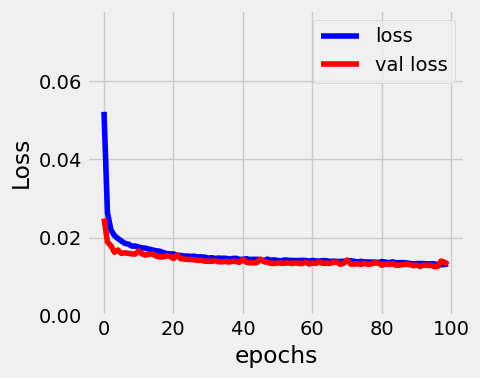

In [345]:
plot_train_val_history_regressor(history)

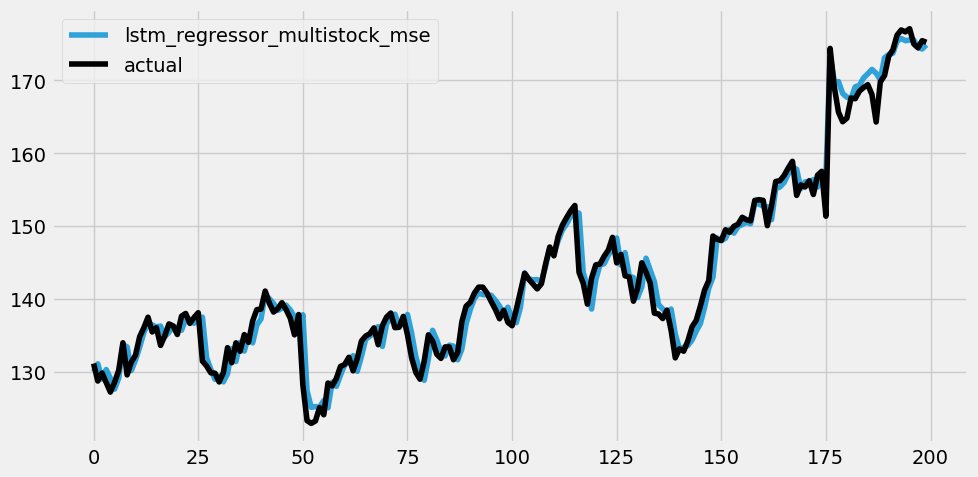

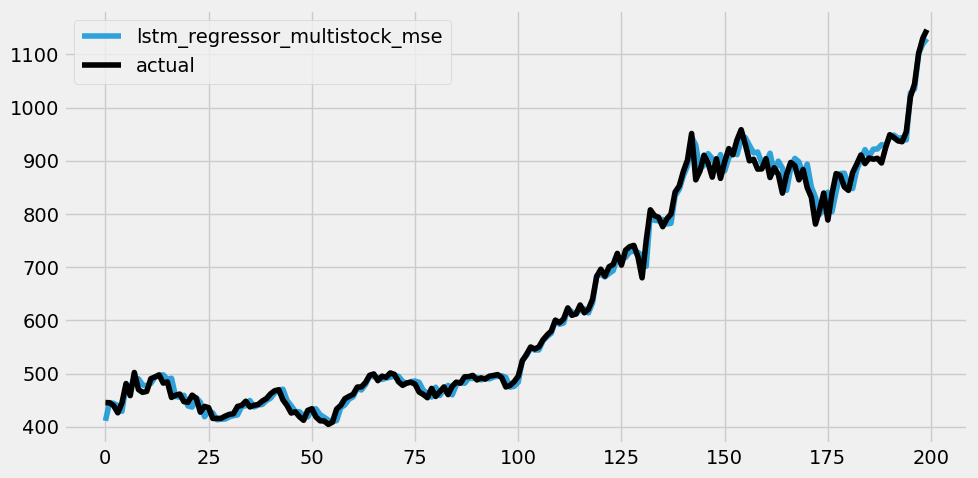

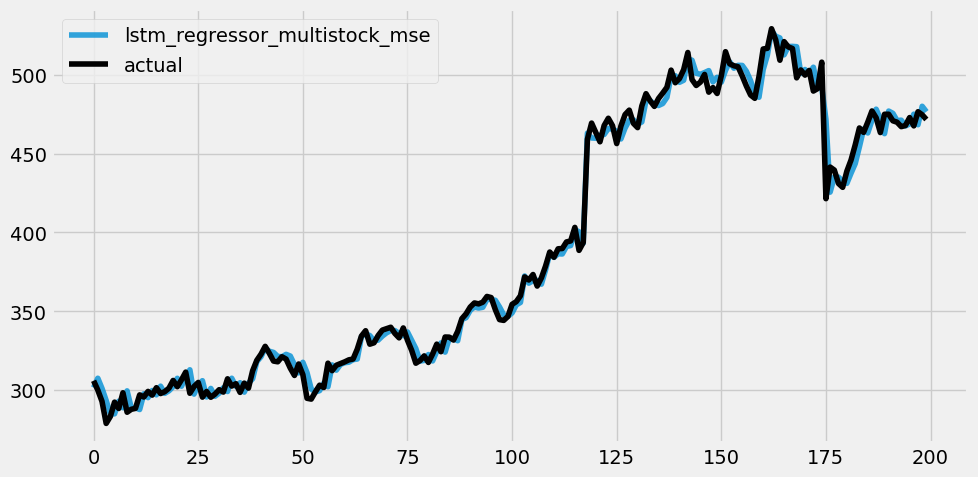

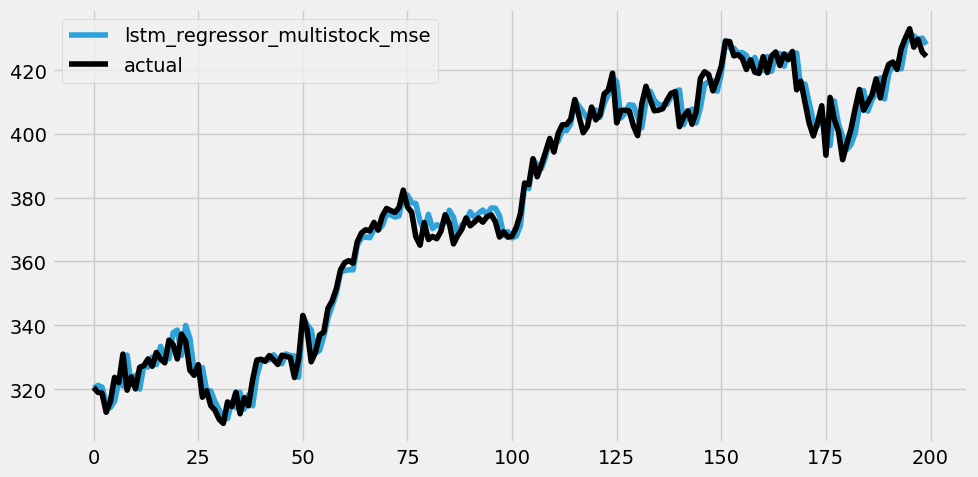

In [348]:
# Use above trained "generic LSTM" to fit other stocks not used in training
n_window, n_forecast, feature, _tic = 40, 1, 'Open', ['GOOGL','NVDA','META','MSFT']  #['AMZN','JPM','TSM','BABA']  
for ticker in _tic: 
    metadata = create_time_windows(pd.DataFrame({ticker:dfs[ticker][feature]}), n_window = n_window, n_forecast = n_forecast)
    train, val, test = train_val_test_split(metadata)
    plot_1dayforecast(test,begin_index=-200,models={'lstm_regressor_multistock_mse':lstm_regressor_mse})

# 4. Multifeature forecast 
Stack stock features horizontally rather than vertically 

In [209]:
n_window, n_forecast, feature, _tic = 40, 1, 'Open', ['MSFT','GOOGL','NVDA','META']
metadata = create_time_windows(pd.DataFrame({ticker:dfs[ticker][feature] for ticker in _tic}).dropna(), n_window = n_window, n_forecast = n_forecast)
train, val, test = train_val_test_split(metadata)

lstm_regressor_mse = keras.Sequential([keras.Input(shape=(None,4)),
                          keras.layers.LSTM(32,return_sequences=True),
                          keras.layers.Dropout(0.2),
                          keras.layers.LSTM(32,return_sequences=False),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(4)])

trainy = train['y'].copy().reshape(-1,4)
valy = val['y'].copy().reshape(-1,4)
lstm_regressor_mse.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='mse')
history = lstm_regressor_mse.fit(train['X'],trainy, batch_size= 32,
                     epochs = 100,validation_data=(val['X'],valy))

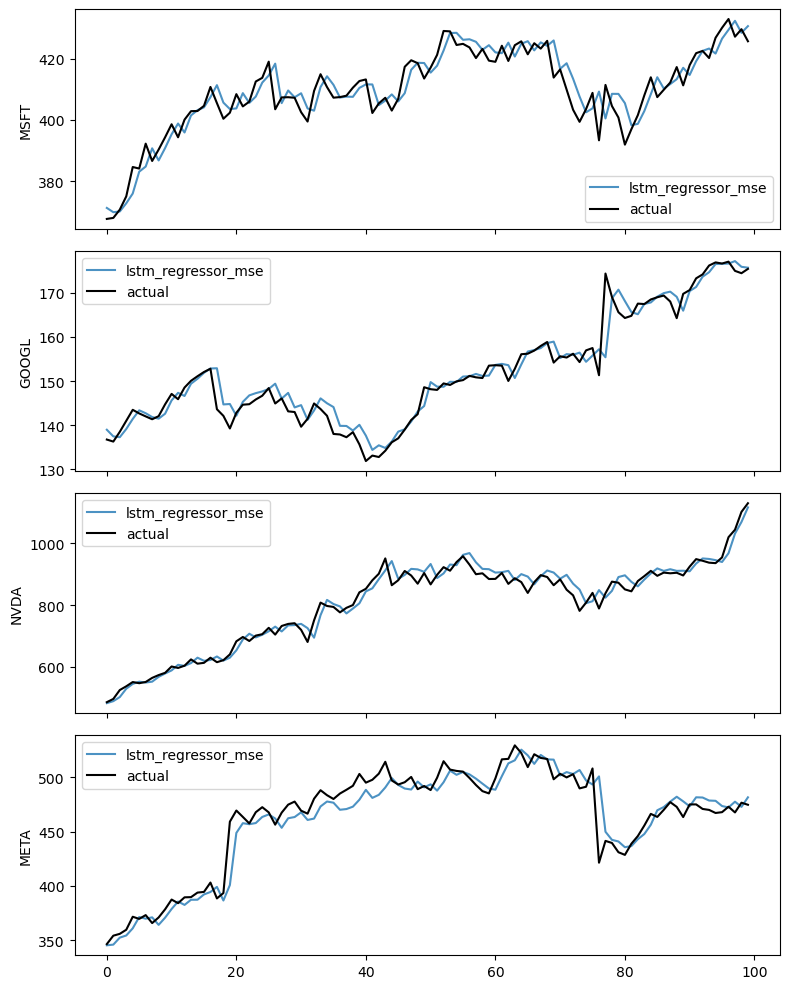

In [223]:
# plotting 
begin_index = -100

yactual = test['y'].copy().reshape(-1,1,4)
for i in range(yactual.shape[0]):
    yactual[i,:,:] = test['scaler'][i].inverse_transform(yactual[i,:,:])

fig,ax = plt.subplots(4,1,figsize=(8,10),sharex=True)

for label, model in {'lstm_regressor_mse':lstm_regressor_mse}.items():
    ypred = model(test['X']).numpy().reshape(-1,1,4)
    for i in range(ypred.shape[0]):
        ypred[i,:,:] = test['scaler'][i].inverse_transform(ypred[i,:,:])

    for j in range(4):
        ax[j].plot(ypred[begin_index:,0,j],"-",label=label,alpha=0.8)

for j in range(4):
    ax[j].plot(yactual[begin_index:,0,j],"k-",label='actual')

for j in range(4):
    ax[j].legend()
    ax[j].set_ylabel(_tic[j])

plt.tight_layout()
plt.show()
plt.close(fig)

## 5. Multiday forecasting 

In [332]:
n_window, n_forecast, feature, ticker = 40, 5, 'Open', 'MSFT'
metadata = create_time_windows(pd.DataFrame({ticker:dfs[ticker][feature]}), n_window = n_window, n_forecast = n_forecast)
train, val, test = train_val_test_split(metadata)

lstm_regressor_mse = keras.Sequential([keras.Input(shape=(None,1)),
                          keras.layers.LSTM(32,return_sequences=True),
                          keras.layers.Dropout(0.2),
                          keras.layers.LSTM(32,return_sequences=False),
                          keras.layers.Dense(n_forecast)])

lstm_regressor_mse.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='mse')
history = lstm_regressor_mse.fit(train['X'],train['y'], batch_size= 32, verbose = 0,
                     epochs = 20,validation_data=(val['X'],val['y']))

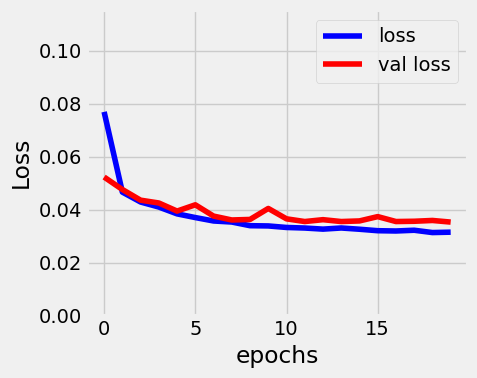

In [333]:
plot_train_val_history_regressor(history)

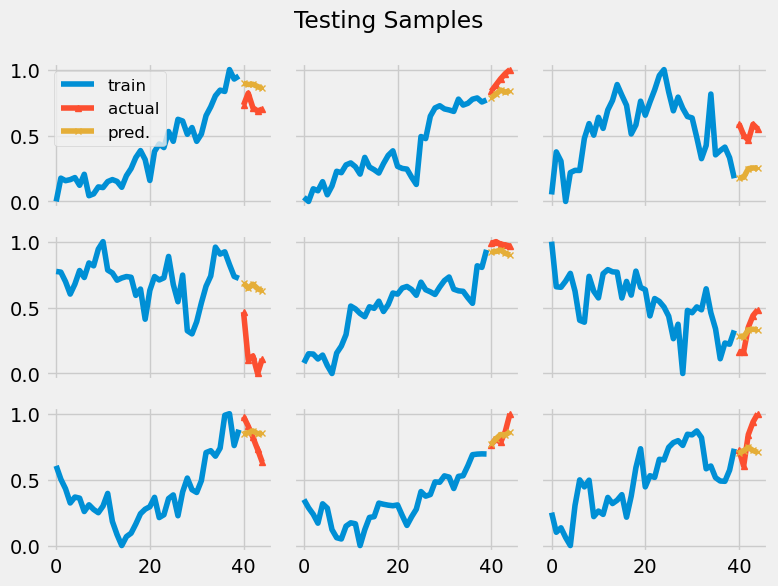

In [342]:
plot_rolling_time_window(test['X'],test['y'],model=lstm_regressor_mse,mode='Testing Samples')